In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import Nmf, LsiModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

import warnings
warnings.filterwarnings('ignore')

nlp = spacy.load('en_core_web_md')


C:\Users\tschwoer\Envs\sma\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


# 1. Documents

In [2]:
texts = [['Bayern Munich is football bundesliga champion of the season 2022'],
         ['Bayern Munich won bundesliga match against Borussia Dortmund'],
         ['CEO of football club Bayern Munich is Oliver Kahn.'],
         ['German favorites for winning the Champions League are Bayern Munich and Borussia Dortmund.'],
         ['Football bundesliga to open stadiums after covid lockdown.'],
         ['Bayern Munich has been champion of the German bundesliag 10 times in a row.'],
         ['Important German political parties are SPD, Green party, CDU, FDP, CSU, and AFD'],
         ['Favorites for political election in German state Schleswig-Holstein are SPD and CDU.'],
         ['German minister Spiegel (Green party) resignes over scandal in the state of Rheinland-Palatine.'],
         ['German president Steinmeier (SPD) holds speech on Ukraine.'],
         ['Ex chancelor Schröder (SPD) drops membership of football club Borussia Dortmund due to scandal.'],
         ['Gerhard Schröder (SPD) is criticized for friendship to russian president'],
         ['Important positions of the German political system are president, chancellor, and the president of the bundesrat and bundesrat.']]

df = pd.DataFrame(texts, columns=['text'])
df.style


,text
0,Bayern Munich is football bundesliga champion of the season 2022
1,Bayern Munich won bundesliga match against Borussia Dortmund
2,CEO of football club Bayern Munich is Oliver Kahn.
3,German favorites for winning the Champions League are Bayern Munich and Borussia Dortmund.
4,Football bundesliga to open stadiums after covid lockdown.
5,Bayern Munich has been champion of the German bundesliag 10 times in a row.
6,"Important German political parties are SPD, Green party, CDU, FDP, CSU, and AFD"
7,Favorites for political election in German state Schleswig-Holstein are SPD and CDU.
8,German minister Spiegel (Green party) resignes over scandal in the state of Rheinland-Palatine.
9,German president Steinmeier (SPD) holds speech on Ukraine.


# 2. Normalize Documents

In [3]:
def normalize_document(doc, stopwords):
    # keep words and spaces
    doc = re.sub(r'[^\w\s]', '', doc)
    # lower case
    doc = doc.lower()
    # lemmatize and remove stopwords
    nlpdoc = nlp(doc)
    lemmas = [word.lemma_ for word in nlpdoc if word.lemma_ not in stopwords]
    return lemmas


en_stopwords = nlp.Defaults.stop_words
df["normalized"] = df.text.apply(
    lambda x: normalize_document(x, stopwords=en_stopwords))
df.style


,text,normalized
0,Bayern Munich is football bundesliga champion of the season 2022,"['bayern', 'munich', 'football', 'bundesliga', 'champion', 'season', '2022']"
1,Bayern Munich won bundesliga match against Borussia Dortmund,"['bayern', 'munich', 'win', 'bundesliga', 'match', 'borussia', 'dortmund']"
2,CEO of football club Bayern Munich is Oliver Kahn.,"['ceo', 'football', 'club', 'bayern', 'munich', 'oliver', 'kahn']"
3,German favorites for winning the Champions League are Bayern Munich and Borussia Dortmund.,"['german', 'favorite', 'win', 'champion', 'league', 'bayern', 'munich', 'borussia', 'dortmund']"
4,Football bundesliga to open stadiums after covid lockdown.,"['football', 'bundesliga', 'open', 'stadium', 'covid', 'lockdown']"
5,Bayern Munich has been champion of the German bundesliag 10 times in a row.,"['bayern', 'munich', 'champion', 'german', 'bundesliag', '10', 'time', 'row']"
6,"Important German political parties are SPD, Green party, CDU, FDP, CSU, and AFD","['important', 'german', 'political', 'party', 'spd', 'green', 'party', 'cdu', 'fdp', 'csu', 'afd']"
7,Favorites for political election in German state Schleswig-Holstein are SPD and CDU.,"['favorite', 'political', 'election', 'german', 'state', 'schleswigholstein', 'spd', 'cdu']"
8,German minister Spiegel (Green party) resignes over scandal in the state of Rheinland-Palatine.,"['german', 'minister', 'spiegel', 'green', 'party', 'resigne', 'scandal', 'state', 'rheinlandpalatine']"
9,German president Steinmeier (SPD) holds speech on Ukraine.,"['german', 'president', 'steinmeier', 'spd', 'hold', 'speech', 'ukraine']"


# 3. Create Bag of Words

In [4]:
dictionary = Dictionary(df.normalized)
dictionary.id2token
dictionary.most_common(10)
len(dictionary)
dictionary.filter_extremes(no_below=2, no_above=0.5)
len(dictionary)
corpus = [dictionary.doc2bow(text) for text in df.normalized]


# 4. Run LDA Algorithm

In [5]:
lda = LdaModel(corpus=corpus, num_topics=2, id2word=dictionary,
               iterations=100, alpha='asymmetric', random_state=1, passes=5)


# 5. Interpretation

## Understanding documents

In [6]:

# First text
i = 0
df.text[i]                                    # Document
lda.get_document_topics(corpus[i])            # Topic Distribution of Document
# Word Distribution for most relevant topic
lda.show_topic(0)


[('bayern', 0.08968116),
 ('munich', 0.08965953),
 ('football', 0.073210604),
 ('spd', 0.07081615),
 ('dortmund', 0.0570629),
 ('borussia', 0.057046298),
 ('champion', 0.05698477),
 ('bundesliga', 0.056870505),
 ('party', 0.056542803),
 ('club', 0.04070514)]

In [7]:
# Add most important topic to dataframe
topics = lda.get_document_topics(corpus)
df['top_topic'] = [sorted(topics[i], key=lambda x: x[1], reverse=True)[
    0][0] for i, text in enumerate(df.text)]
df['top_topic_p'] = [sorted(lda[corpus][i], key=lambda x: x[1], reverse=True)[
    0][1] for i, text in enumerate(df.text)]
df.style


,text,normalized,top_topic,top_topic_p
0,Bayern Munich is football bundesliga champion of the season 2022,"['bayern', 'munich', 'football', 'bundesliga', 'champion', 'season', '2022']",0,0.936937
1,Bayern Munich won bundesliga match against Borussia Dortmund,"['bayern', 'munich', 'win', 'bundesliga', 'match', 'borussia', 'dortmund']",0,0.945695
2,CEO of football club Bayern Munich is Oliver Kahn.,"['ceo', 'football', 'club', 'bayern', 'munich', 'oliver', 'kahn']",0,0.924195
3,German favorites for winning the Champions League are Bayern Munich and Borussia Dortmund.,"['german', 'favorite', 'win', 'champion', 'league', 'bayern', 'munich', 'borussia', 'dortmund']",0,0.952364
4,Football bundesliga to open stadiums after covid lockdown.,"['football', 'bundesliga', 'open', 'stadium', 'covid', 'lockdown']",0,0.873616
5,Bayern Munich has been champion of the German bundesliag 10 times in a row.,"['bayern', 'munich', 'champion', 'german', 'bundesliag', '10', 'time', 'row']",0,0.905655
6,"Important German political parties are SPD, Green party, CDU, FDP, CSU, and AFD","['important', 'german', 'political', 'party', 'spd', 'green', 'party', 'cdu', 'fdp', 'csu', 'afd']",0,0.929125
7,Favorites for political election in German state Schleswig-Holstein are SPD and CDU.,"['favorite', 'political', 'election', 'german', 'state', 'schleswigholstein', 'spd', 'cdu']",0,0.925803
8,German minister Spiegel (Green party) resignes over scandal in the state of Rheinland-Palatine.,"['german', 'minister', 'spiegel', 'green', 'party', 'resigne', 'scandal', 'state', 'rheinlandpalatine']",0,0.922337
9,German president Steinmeier (SPD) holds speech on Ukraine.,"['german', 'president', 'steinmeier', 'spd', 'hold', 'speech', 'ukraine']",1,0.730931


## Understanding topics

In [8]:
lda.print_topics(num_words=10)
lda.get_topics().sum(axis=1)
pd.DataFrame(lda.get_topics(), columns=dictionary.values()
             ).T.sort_values(0, ascending=False)

,0,1
bayern,0.089681,0.028819
munich,0.089660,0.028893
football,0.073211,0.029245
spd,0.070816,0.093568
dortmund,0.057063,0.028564
borussia,0.057046,0.028621
champion,0.056985,0.028832
bundesliga,0.056871,0.029224
party,0.056543,0.030349
club,0.040705,0.028603


In [9]:
# Visualizing topics
lda_viz = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(lda_viz)

# 6. Optimal number of topics

Text(0, 0.5, 'Coherence score u_mass')

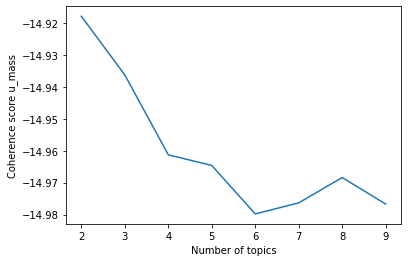

In [10]:
# Choose number of topics to maximize topic coherence"

topics = []
coherence = []
for i in range(2, 10, 1):
    ldamodel = LdaModel(corpus=corpus, num_topics=i, id2word=dictionary,
                        iterations=50, alpha='auto', random_state=1, passes=5)
    u_mass = CoherenceModel(model=ldamodel, corpus=corpus,
                            dictionary=dictionary, coherence='u_mass')   # 'c_v'
    topics.append(i)
    coherence.append(u_mass.get_coherence())

fig, ax = plt.subplots()
ax.plot(topics, coherence)
ax.set_xlabel("Number of topics")
ax.set_ylabel("Coherence score u_mass")


# 7. Dealing with new, unseen documents

In [11]:
new_docs = [
    "Holstein Kiel wins derby against Hamburger SV in second football Bundesliga.",
    "CDU, FDP, and the green party currently form a coalition in Schleswig-Holsteins parliament."]
new_docs_norm = [normalize_document(doc, en_stopwords) for doc in new_docs]
new_corpus = [dictionary.doc2bow(doc) for doc in new_docs_norm]

# Infer topics for new documents
lda.get_document_topics(corpus)[0]
lda.get_document_topics(corpus)[1]

[(0, 0.94569457), (1, 0.05430549)]

In [12]:
# Update the model by incrementally training on the new corpus
lda.update(new_corpus)
lda.get_document_topics(corpus)[0]

[(0, 0.9273822), (1, 0.07261783)]

# 8. Saving the model

In [13]:
# Save model to disk
lda.save("model")

# Load pretrained model from disk
lda2 = LdaModel.load("model")


# 9. Other algorithms

In [ ]:

nmf = Nmf(corpus, num_topics=3, id2word=dictionary)
lsi = LsiModel(corpus, num_topics=2, id2word=dictionary)
...
